# Leitura da base + Informações

In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [3]:
# Load environment variables from a .env file
load_dotenv()

gs_url = os.getenv("GS_DATASET_URL")
if not gs_url:
	raise RuntimeError("Environment variable GS_DATASET_URL is not set. Please set it or provide the dataset URL.")

df = pd.read_parquet(gs_url)

# 1. Dataset info
print(df.info())
print("==" * 40)
print(df.describe())
print("==" * 40)

# 2. Missing values
print("Missing values: ", df.isna().sum())
print("==" * 40)
print("Missing values per column: ", df.isna().mean().sort_values(ascending=False))
print("==" * 40)

# 3. General information
print("Total rows:", df.shape[0])
print("Unique card written texts:", df["card_written_text"].nunique())
print("Unique card spoken texts:", df["card_spoken_text"].nunique())
print("Unique click locations:", df["click_location"].nunique())
print("Unique users:", df["user_uuid"].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672888 entries, 0 to 1672887
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   event_date          1672888 non-null  object
 1   event_timestamp     1672888 non-null  int64 
 2   device_language     1672888 non-null  object
 3   click_city          1672888 non-null  object
 4   click_country       1672888 non-null  object
 5   click_location      1672888 non-null  object
 6   os_version          1672888 non-null  object
 7   livox_version       1672888 non-null  object
 8   holder_uuid         1656134 non-null  object
 9   user_uuid           1672888 non-null  object
 10  card_mode           1672888 non-null  object
 11  card_is_leaf        1672888 non-null  object
 12  card_written_text   1609783 non-null  object
 13  card_spoken_text    1641527 non-null  object
 14  card_symbol_name    906853 non-null   object
 15  card_current_state  1672888 non-

# Generating graphs

## Relations between users

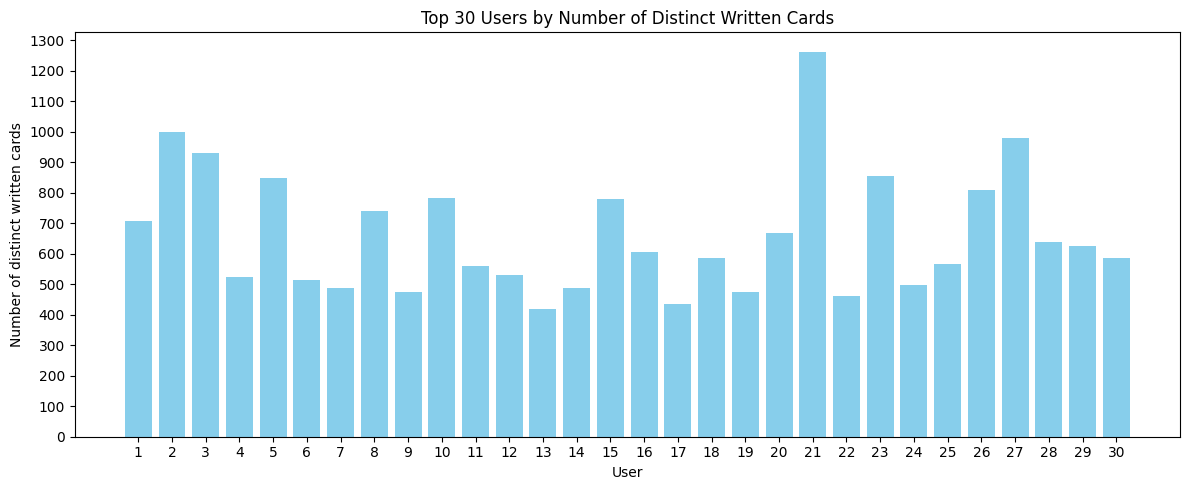

In [5]:
# 1.1 Unique card_written_text values per user_uuid
cards_per_user = df.groupby("user_uuid")["card_written_text"] \
                   .nunique() \
                   .dropna()  # Removing users without written text

# 1.2 Plot of the top 30 users with the most distinct cards
top30 = cards_per_user.nlargest(30).sort_index()

# 1.3 Setting up the plot axes
x = np.arange(1, len(top30) + 1)   # [1,2,3,...,30]
y = top30.to_numpy(dtype=float)    # Converting to float

# 1.4 Plotting the graph
plt.figure(figsize=(12,5))
plt.bar(x, y, color="skyblue")
plt.title(f"Top 30 Users by Number of Distinct Written Cards")
plt.xlabel("User")
plt.ylabel("Number of distinct written cards")

plt.xticks(x)
# Y ticks every 100
max_y = int(y.max()) + 100
plt.yticks(np.arange(0, max_y, 100)) # Interval of 100 for the Y axis

plt.tight_layout()
plt.savefig("../reports/figures/top30_users_distinct_written_cards.png", dpi=300, bbox_inches="tight")
plt.show()

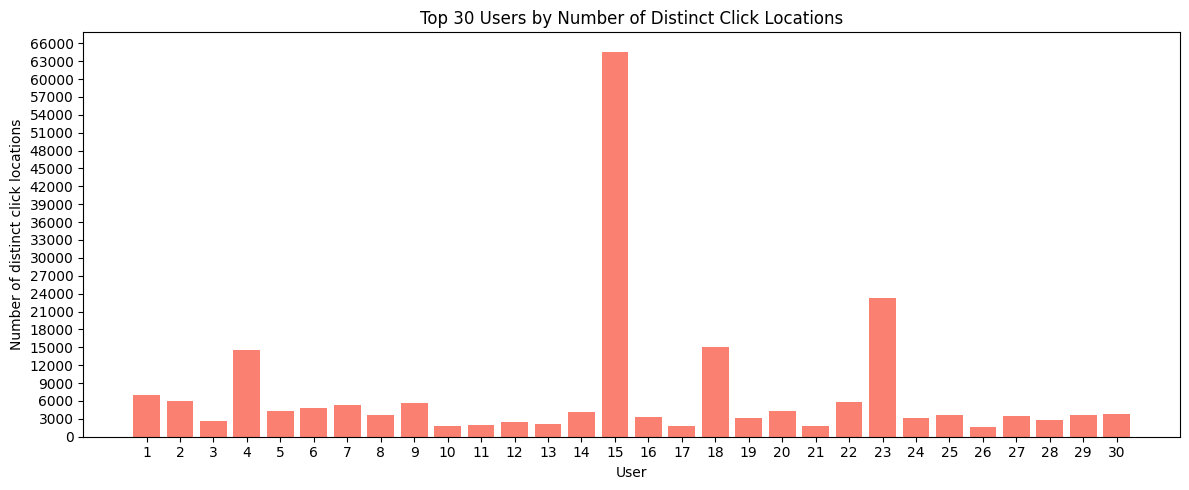

In [6]:
# 2.1 Unique click_location values per user_uuid
locs_per_user = df.groupby("user_uuid")["click_location"].nunique().dropna()

# 2.2 Plot of the top 30 users with the most distinct click locations
top30_locs = locs_per_user.nlargest(30).sort_index()

# 2.3 Setting up the plot axes
x = np.arange(1, len(top30_locs) + 1)
y = top30_locs.to_numpy(dtype=float)

# 2.4 Plotting the graph
plt.figure(figsize=(12,5))
plt.bar(x, y, color="salmon")
plt.title("Top 30 Users by Number of Distinct Click Locations")
plt.xlabel("User")
plt.ylabel("Number of distinct click locations")

plt.xticks(x)
max_y = int(y.max()) + 3000
plt.yticks(np.arange(0, max_y, 3000)) # Intervalo de 5000 para o eixo Y

plt.tight_layout()
plt.savefig("../reports/figures/top30_users_distinct_click_locations.png", dpi=300, bbox_inches="tight")
plt.show()

## Relations between day and time
Time periods:
- midnight: (0-5h)
- dawn: (6-8h)
- morning: (9-11h)
- noon: (12-14h)
- afternoon: (15-17h)
- evening: (18-20h)
- night: (21-23h)

/tmp/ipykernel_133835/2379847527.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loc_counts = df.groupby('period')['click_location'].count()


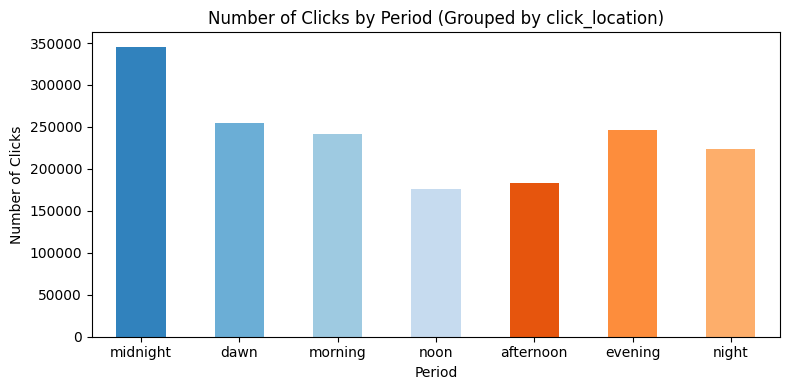

In [8]:
# 3.1 Clicks by time periods
df["datetime"] = pd.to_datetime(
  df["event_timestamp"] * 100,
  unit="ns",
  origin="unix",
  errors="coerce"
)
df['hour'] = df['datetime'].dt.hour

# 3.2 Function to map hour → period
def get_period(h):
  if 6 <= h <= 8:
    return 'dawn'
  elif 9 <= h <= 11:
    return 'morning'
  elif 12 <= h <= 14:
    return 'noon'
  elif 15 <= h <= 17:
    return 'afternoon'
  elif 18 <= h <= 20:
    return 'evening'
  elif 21 <= h <= 23:
    return 'night'
  else:
    return 'midnight'

df['period'] = df['hour'].apply(get_period)

# 3.3 Custom ordering of periods
period_order = ['midnight','dawn','morning','noon','afternoon','evening','night']
df['period'] = pd.Categorical(df['period'], categories=period_order, ordered=True)

# 3.4 Plot of # of events by click_location over periods
loc_counts = df.groupby('period')['click_location'].count()

# choose a colormap and generate N colors
cmap_loc = plt.get_cmap('tab20c')
colors_loc = [cmap_loc(i) for i in range(len(loc_counts))]

plt.figure(figsize=(8,4))
loc_counts.plot.bar(color=colors_loc) # type: ignore
plt.title("Number of Clicks by Period (Grouped by click_location)")
plt.xlabel("Period")
plt.ylabel("Number of Clicks")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../reports/figures/clicks_by_period_click_location.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_133835/155978147.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_city_period = df_top.pivot_table(


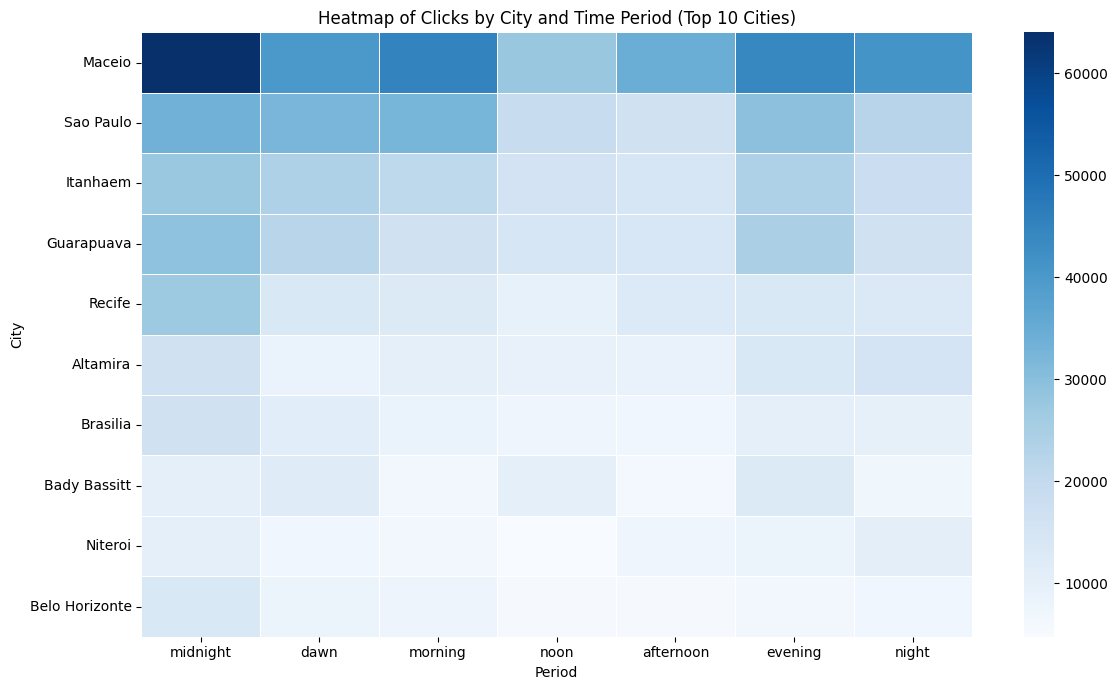

In [15]:
top_cities = df['click_city'].value_counts().head(10).index
df_top = df[df['click_city'].isin(top_cities)]

# Create pivot table: rows = cities, columns = periods
pivot_city_period = df_top.pivot_table(
  index='click_city',
  columns='period',
  values='user_uuid',
  aggfunc='count',
  fill_value=0
)

# Order rows by total clicks descending
pivot_city_period = pivot_city_period.loc[pivot_city_period.sum(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(12, 7))
sns.heatmap(pivot_city_period, cmap="Blues", linewidths=.5)
plt.title("Heatmap of Clicks by City and Time Period (Top 10 Cities)")
plt.xlabel("Period")
plt.ylabel("City")
plt.tight_layout()
plt.savefig("../reports/figures/heatmap_city_period.png", dpi=300, bbox_inches="tight")
plt.show()

## Relations between clicks and cities

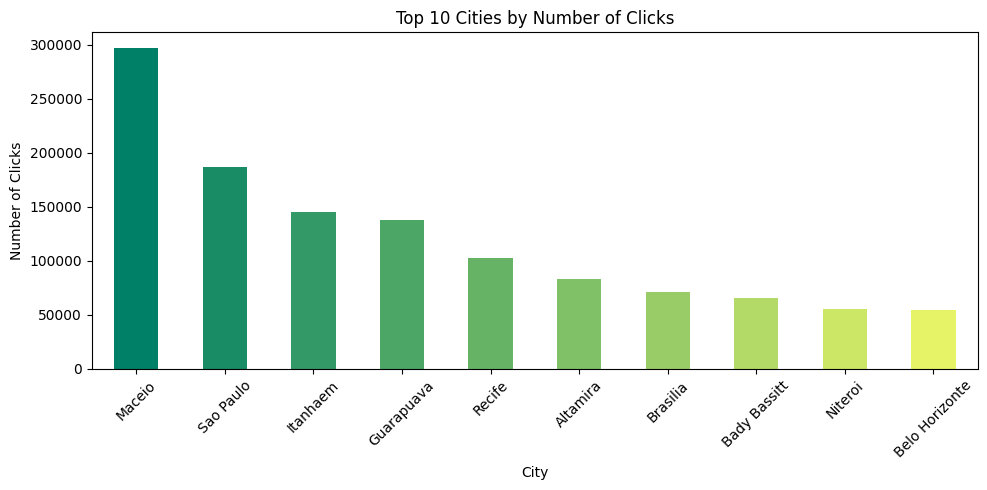

In [27]:
# Contagem total por cidade
city_counts = df['click_city'].value_counts()
top10 = city_counts.head(10)

# choose a colormap and generate N colors
cmap = plt.get_cmap('summer')
colors_top10 = [cmap(i / len(top10)) for i in range(len(top10))]

plt.figure(figsize=(10,5))
top10.plot(kind='bar', color=colors_top10)

plt.title("Top 10 Cities by Number of Clicks")
plt.xlabel("City")
plt.ylabel("Number of Clicks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../reports/figures/top10_clicks_by_city.png", dpi=300, bbox_inches="tight")
plt.show()